<br>

<h2 style="text-align: center; font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: underline; text-transform: none; letter-spacing: 2px; color: blue; background-color: #ffffff;">PERSONALIZED ROUTES: Geographical Network Analysis</h2>
<h5 style="text-align: center; font-family: Verdana; font-size: 12px; font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color: black; background-color: #ffffff;">NOTEBOOK for SECTION 3.2.2 </h5>
<h5 style="text-align: center; font-family: Verdana; font-size: 12px; font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color: black; background-color: #ffffff;">AUTHOR: Luis Rodríguez Ballabriga</h5>


<br>

---

<br>




<p id="toc"></p>

<br><br>

<h1 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; color: blue; background-color: #ffffff;">TABLE OF CONTENTS</h1>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#imports">0&nbsp;&nbsp;&nbsp;&nbsp;IMPORTS</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#shop_relations">1&nbsp;&nbsp;&nbsp;&nbsp;CITY AND SHOPS RELATIONS</a></h3>

---

<h3 style="text-indent: 10vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#algorithm">2&nbsp;&nbsp;&nbsp;&nbsp;ALGORITHM</a></h3>

---

<h3 style="text-indent: 15vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#first">2.1&nbsp;&nbsp;&nbsp;&nbsp;Random Selection (1st option)</a></h3>


---

<h3 style="text-indent: 15vw; font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"><a href="#second">2.2&nbsp;&nbsp;&nbsp;&nbsp;Shortest Route Selection (2nd option)</a></h3>

---

<br>

<a id="imports"></a>

<h1 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #ffffff; color: blue;" id="imports">0&nbsp;&nbsp;IMPORTS&nbsp;&nbsp;&nbsp;&nbsp;<a href="#toc">&#10514;</a></h1>

---

In [13]:
#ENV SET UP
import warnings
warnings.filterwarnings("ignore")

from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import pandas as pd

import geopandas as gpd
import networkx as nx
import osmnx as ox

from shapely.geometry import LineString, Point

from itertools import combinations

print(f'– PANDAS VERSION: {pd.__version__}')
print(f'– GEOPANDAS VERSION: {gpd.__version__}')
print(f'– NETWORKX VERSION: {nx.__version__}')
print(f'– OSMNX VERSION: {ox.__version__}')

– PANDAS VERSION: 1.3.3
– GEOPANDAS VERSION: 0.10.2
– NETWORKX VERSION: 2.6.3
– OSMNX VERSION: 1.1.2


<br>

<a id="vector_data"></a>

<h1 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; color: blue; background-color: #ffffff;" id="shop_relations">1&nbsp;&nbsp;CITY AND SHOPS RELATIONS&nbsp;&nbsp;&nbsp;&nbsp;<a href="#toc">&#10514;</a></h1>

---

We first need to load the graphs for the different cities we will be working on.

In [14]:
cities_list = ['barcelona', 'madrid', 'london', 'new_york']

In [31]:
graph_bcn = nx.read_gpickle("./Graphs/barcelona.gpickle")
graph_mad = nx.read_gpickle("./Graphs/madrid.gpickle")
graph_lnd = nx.read_gpickle("./Graphs/london.gpickle")
graph_nyc = nx.read_gpickle("./Graphs/new_york.gpickle")

Let's detail the process for the city of Barcelona, and after we will replicate it for the other cities.

We first get the nodes and edges of the projected graph of the city.

In [16]:
graph_bcn_prj = ox.project_graph(graph_bcn)
nodes_bcn_prj, edges_bcn_prj = ox.graph_to_gdfs(graph_bcn_prj, nodes=True, edges=True)

Then we load the dataset with the retail bussiness.

In [17]:
retail_bcn = pd.read_csv('./Datasets/retail_bcn_selec_cats.csv', sep = ',', encoding = 'utf-8')

We sent to numeric all the columns that formed by numbers, as some of them are text.

In [18]:
retail_bcn = retail_bcn.apply(lambda col: pd.to_numeric(col, errors='coerce'))

Now, we are able to set the tolerance for each point.

In [19]:
data_tolerance = ({ 'x': nodes_bcn_prj['x'].values, 
    'y': nodes_bcn_prj['y'].values, 
    'x_min': nodes_bcn_prj['x'].values - 50,
    'x_max': nodes_bcn_prj['x'].values + 50,
    'y_min': nodes_bcn_prj['y'].values - 50,
    'y_max': nodes_bcn_prj['y'].values + 50 })

df_areas = pd.DataFrame(data = data_tolerance, index = nodes_bcn_prj.index.values)

We can finally create the .csv file with all the relations. For each point we will be have a list of all the retail shops near it.

In [20]:
related = []
for idx in df_areas.index:
    x_min= df_areas['x_min'][idx]
    x_max = df_areas['x_max'][idx]
    y_min = df_areas['y_min'][idx]
    y_max = df_areas['y_max'][idx]
    
    aux = retail_bcn.loc[(x_min <= retail_bcn['X']) & (x_max >= retail_bcn['X']) & (y_min <= retail_bcn['Y']) & (y_max >= retail_bcn['Y'])]

    related.append(' '.join([aux.index[i].astype(str) for i in range(0,len(aux))]))
            
df_relations = pd.DataFrame({
        'osmid': df_areas.index,
        'relations': related
    })

In [23]:
df_relations.to_csv('./Relations/bcn_relations.csv', index=False)

In [24]:
print(df_relations)

            osmid                      relations
0        21638843                               
1      6831738685                               
2      8462014250                               
3      6831706284                               
4        21638845                               
...           ...                            ...
69119  9770464346  12265 12275 12277 12279 12280
69120  9772647642                          12278
69121  9787630832  3089 3090 3091 3092 3633 3634
69122  9787630850  3089 3430 3431 3432 3433 3634
69123  9787635193              18556 18557 29373

[69124 rows x 2 columns]


MADRID

In [25]:
graph_mad_prj = ox.project_graph(graph_mad)
nodes_mad_prj, edges_mad_prj = ox.graph_to_gdfs(graph_mad_prj, nodes=True, edges=True)

In [28]:
retail_mad = pd.read_csv('./Datasets/retail_mad_selec_cats.csv', sep = ',', encoding = 'utf-8')
retail_mad = retail_mad.apply(lambda col: pd.to_numeric(col, errors='coerce'))

data_tolerance = ({ 'x': nodes_mad_prj['x'].values, 
    'y': nodes_mad_prj['y'].values, 
    'x_min': nodes_mad_prj['x'].values - 50,
    'x_max': nodes_mad_prj['x'].values + 50,
    'y_min': nodes_mad_prj['y'].values - 50,
    'y_max': nodes_mad_prj['y'].values + 50 })

df_areas = pd.DataFrame(data = data_tolerance, index = nodes_mad_prj.index.values)

In [29]:
related = []
for idx in df_areas.index:
    x_min= df_areas['x_min'][idx]
    x_max = df_areas['x_max'][idx]
    y_min = df_areas['y_min'][idx]
    y_max = df_areas['y_max'][idx]
    
    aux = retail_mad.loc[(x_min <= retail_mad['X']) & (x_max >= retail_mad['X']) & (y_min <= retail_mad['Y']) & (y_max >= retail_mad['Y'])]

    related.append(' '.join([aux.index[i].astype(str) for i in range(0,len(aux))]))
            
df_relations = pd.DataFrame({
        'osmid': df_areas.index,
        'relations': related
    })

df_relations.to_csv('./Relations/mad_relations.csv', index=False)

print(df_relations)

             osmid relations
0           171946          
1         26513145          
2       1209330272          
3       3280496563          
4           171951          
...            ...       ...
121971  9794980238          
121972  9794980245          
121973  9794980232          
121974  9795159931          
121975  9795159935          

[121976 rows x 2 columns]


LONDON

In [32]:
graph_lnd_prj = ox.project_graph(graph_lnd)
nodes_lnd_prj, edges_lnd_prj = ox.graph_to_gdfs(graph_lnd_prj, nodes=True, edges=True)

In [33]:
retail_lnd = pd.read_csv('./Datasets/retail_lnd_selec_cats.csv', sep = ',', encoding = 'utf-8')
retail_lnd = retail_lnd.apply(lambda col: pd.to_numeric(col, errors='coerce'))

data_tolerance = ({ 'x': nodes_lnd_prj['x'].values, 
    'y': nodes_lnd_prj['y'].values, 
    'x_min': nodes_lnd_prj['x'].values - 50,
    'x_max': nodes_lnd_prj['x'].values + 50,
    'y_min': nodes_lnd_prj['y'].values - 50,
    'y_max': nodes_lnd_prj['y'].values + 50 })

df_areas = pd.DataFrame(data = data_tolerance, index = nodes_lnd_prj.index.values)

In [34]:
related = []
for idx in df_areas.index:
    x_min= df_areas['x_min'][idx]
    x_max = df_areas['x_max'][idx]
    y_min = df_areas['y_min'][idx]
    y_max = df_areas['y_max'][idx]
    
    aux = retail_lnd.loc[(x_min <= retail_lnd['X']) & (x_max >= retail_lnd['X']) & (y_min <= retail_lnd['Y']) & (y_max >= retail_lnd['Y'])]

    related.append(' '.join([aux.index[i].astype(str) for i in range(0,len(aux))]))
            
df_relations = pd.DataFrame({
        'osmid': df_areas.index,
        'relations': related
    })

df_relations.to_csv('./Relations/lnd_relations.csv', index=False)

print(df_relations)

             osmid relations
0            78112          
1         25508583          
2         25508584          
3            99880          
4       5183504102          
...            ...       ...
400130  9795986927          
400131  9795986971          
400132  9796275316          
400133  9796289218          
400134  9796289217          

[400135 rows x 2 columns]


NEW YORK

In [35]:
graph_nyc_prj = ox.project_graph(graph_nyc)
nodes_nyc_prj, edges_nyc_prj = ox.graph_to_gdfs(graph_nyc_prj, nodes=True, edges=True)

In [36]:
retail_nyc = pd.read_csv('./Datasets/retail_nyc_selec_cats.csv', sep = ',', encoding = 'utf-8')
retail_nyc = retail_nyc.apply(lambda col: pd.to_numeric(col, errors='coerce'))

data_tolerance = ({ 'x': nodes_nyc_prj['x'].values, 
    'y': nodes_nyc_prj['y'].values, 
    'x_min': nodes_nyc_prj['x'].values - 50,
    'x_max': nodes_nyc_prj['x'].values + 50,
    'y_min': nodes_nyc_prj['y'].values - 50,
    'y_max': nodes_nyc_prj['y'].values + 50 })

df_areas = pd.DataFrame(data = data_tolerance, index = nodes_nyc_prj.index.values)

In [37]:
related = []
for idx in df_areas.index:
    x_min= df_areas['x_min'][idx]
    x_max = df_areas['x_max'][idx]
    y_min = df_areas['y_min'][idx]
    y_max = df_areas['y_max'][idx]
    
    aux = retail_nyc.loc[(x_min <= retail_nyc['X']) & (x_max >= retail_nyc['X']) & (y_min <= retail_nyc['Y']) & (y_max >= retail_nyc['Y'])]

    related.append(' '.join([aux.index[i].astype(str) for i in range(0,len(aux))]))
            
df_relations = pd.DataFrame({
        'osmid': df_areas.index,
        'relations': related
    })

df_relations.to_csv('./Relations/nyc_relations.csv', index=False)

print(df_relations)

             osmid relations
0         30807314          
1       4332491202          
2       2057103273          
3       6579409036          
4       1203806263          
...            ...       ...
191707  9795578895          
191708  9795578901          
191709  9795578900          
191710  9795578915          
191711  9795879913          

[191712 rows x 2 columns]


<br>

<a id="shortest_path"></a>

<h1 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; color: blue; background-color: #ffffff;" id="algorithm">2&nbsp;&nbsp;ALGORITHM&nbsp;&nbsp;&nbsp;&nbsp;<a href="#toc">&#10514;</a></h1>

---


Here we are going to explain the different versions of the algorithm we have developed. We are going to apply it to the Barcelona dataset (as usual) but it is a generic code so it can easily used for the other cities in the dataset.

Following the examples of previous notebooks, here we are going to use the same source and target, the faculty of Physics and Chemistry and the faculty of Mathematics and Computer Science of the University of Barcelona.

We start loading the relations dataset created above.

In [60]:
relations = pd.read_csv('./Relations/bcn_relations.csv')

relations = relations.set_index('osmid')

Now we need to round the values of the coordinates, so that we can define some constraints.

In [61]:
nodes_bcn_prj_aux = nodes_bcn_prj.round(decimals=6)

Now, like in the *network analysis* notebook, we can define the source and the target.


In [62]:
source_aux = nodes_bcn_prj_aux.query('lon == 2.116778 & lat == 41.385310')
source_point = source_aux.geometry.values[0]

target_aux = nodes_bcn_prj_aux.query('lon == 2.164115  & lat == 41.386310')
target_point = target_aux.geometry.values[0]

In [63]:
source_xy = (source_point.y, source_point.x)
target_xy = (target_point.y, target_point.x)

source_node = ox.get_nearest_node(graph_bcn_prj, source_xy, method='euclidean')
target_node = ox.get_nearest_node(graph_bcn_prj, target_xy, method='euclidean')

s_closest = nodes_bcn_prj.loc[source_node]
t_closest = nodes_bcn_prj.loc[target_node]

We generate the shortest path between the two points.

In [64]:
route = nx.shortest_path(G=graph_bcn_prj, source=source_node, target=target_node, weight='length')

From it, we can obtain all the points the route passes through.

In [65]:
route_nodes = nodes_bcn_prj.loc[route]
print(route_nodes)

                       y              x  street_count       lon        lat  \
osmid                                                                        
7234707898  4.581908e+06  426153.570959             3  2.116778  41.385311   
7234707906  4.581924e+06  426203.352586             3  2.117371  41.385458   
8512174175  4.581939e+06  426250.004346             3  2.117928  41.385596   
7159551275  4.581943e+06  426260.899280             5  2.118057  41.385633   
7159551277  4.581946e+06  426266.532266             3  2.118124  41.385661   
...                  ...            ...           ...       ...        ...   
5167682775  4.581920e+06  430022.776667             3  2.163048  41.385766   
2989750377  4.581916e+06  430027.017528             4  2.163100  41.385729   
3314271770  4.581978e+06  430092.462439             4  2.163875  41.386294   
3314271771  4.581969e+06  430101.225992             4  2.163981  41.386209   
26057307    4.581980e+06  430112.555020             4  2.164115 

With this points we can create a line defined by all of them, we will call this the *route line*.

In [66]:
route_line = LineString(list(route_nodes.geometry.values))

print(route_line)

LINESTRING (426153.5709592552 4581907.927239909, 426203.35258623 4581923.79697973, 426250.0043462124 4581938.621922326, 426260.8992797654 4581942.663559363, 426266.5322664662 4581945.659561061, 426272.0052597556 4581947.724542076, 426284.0424667303 4581952.265328391, 426287.6183964194 4581953.616823555, 426348.8218818109 4581973.612705246, 426357.4208287075 4581976.367669784, 426367.2586676233 4581979.254392794, 426374.3821116794 4581981.635767235, 426418.772048169 4581996.129469213, 426431.5984132179 4582000.173950164, 426459.5915911261 4582009.005330447, 426514.7246632175 4582027.476481844, 426592.3770786787 4582053.503051965, 426589.7761580027 4582060.890695844, 426616.1733107869 4582069.872079616, 426704.6128663912 4582098.510817126, 426727.6242438491 4582105.939125558, 426810.9615565263 4582132.85426635, 426856.4550639407 4582147.517110646, 426863.3341396736 4582149.745983953, 426923.5933966497 4582169.312063033, 426999.8453433854 4582194.413308029, 427020.7707991681 4582201.51936

Now we create a dataframe with all the points of the route, to facilitate further treatments.

In [67]:
points = list(route_line.coords)
df_points = pd.DataFrame(points)
df_points.columns = ['x', 'y']

print(df_points)

                 x             y
0    426153.570959  4.581908e+06
1    426203.352586  4.581924e+06
2    426250.004346  4.581939e+06
3    426260.899280  4.581943e+06
4    426266.532266  4.581946e+06
..             ...           ...
115  430022.776667  4.581920e+06
116  430027.017528  4.581916e+06
117  430092.462439  4.581978e+06
118  430101.225992  4.581969e+06
119  430112.555020  4.581980e+06

[120 rows x 2 columns]


We now need the osmid of this points, to later check the relations csv and obtain all the related locals. For it we will be using dictionaries that will speed up the process.

In [68]:
dict_x_zip = zip(nodes_bcn_prj.index, nodes_bcn_prj['x'])
dict_y_zip = zip(nodes_bcn_prj.index, nodes_bcn_prj['y'])

dict_x = dict(dict_x_zip)
dict_y = dict(dict_y_zip)

In [69]:
dict_x

{21638843: 432058.9329716993,
 6831738685: 432061.67633100203,
 8462014250: 432054.63969240437,
 6831706284: 432065.5937497979,
 21638845: 432071.1859600899,
 885308258: 432067.92837743484,
 885308314: 432087.0758851438,
 21638855: 432167.2228318028,
 1401485279: 432168.7506420774,
 4229056903: 432174.81144975696,
 6831706278: 432152.55128579173,
 21638859: 432157.16732408333,
 3643971036: 432166.8358988877,
 6831706254: 432137.26983915234,
 689473874: 432160.1286130452,
 21638861: 432104.2763966239,
 6984806821: 432107.8222781475,
 3643971040: 432114.2712832395,
 9249495240: 432076.4443829842,
 21638867: 432179.14602368925,
 6984972069: 432185.16645864217,
 1636238503: 432163.9857497616,
 6984972072: 432177.2097374509,
 6984972066: 432181.31722820766,
 21638868: 432266.1827703576,
 30343649: 432251.6683439255,
 8253197813: 432268.7794990282,
 8253197816: 432264.56256747234,
 30343654: 432280.7307313167,
 21638869: 432323.98758063815,
 30343672: 432338.83619284665,
 242318729: 432309.4

After checking it, we have seen that all coordinates are unique, so we will be using one of the dictionaries above to get the osmid.

In [70]:
relation_osmid = []
for pt in df_points['x']:
    relation_osmid.append([k for k, v in dict_x.items() if v == pt][0])

print(relation_osmid)

[7234707898, 7234707906, 8512174175, 7159551275, 7159551277, 7234707917, 9545433003, 3394169508, 3394169500, 3394169527, 3394169528, 3394169563, 3394169544, 7234707920, 3394169564, 6096421452, 5678325108, 6374595639, 390227080, 356295267, 6374595635, 765796225, 1375306778, 6248912569, 6248912564, 6248912562, 2126571874, 2087204995, 7252348289, 269384759, 1483923435, 7252669473, 7252397729, 269384878, 7252397728, 8126690996, 269383989, 7252397720, 3191418776, 7252397718, 7252397709, 269379908, 7252397699, 6210812030, 998637904, 269379907, 8197555116, 30558433, 8121946706, 8121946705, 364991353, 3237622868, 9135827929, 9135827928, 1382873567, 8121946700, 8197555138, 8197555125, 6889577892, 6889577894, 2643498765, 2643498764, 5808643406, 5808643410, 1589583456, 5808643405, 5808643416, 5808643390, 5808643413, 5808558189, 5808557738, 9576130236, 9576130240, 5808557749, 1589583445, 5808558186, 7198688932, 6984788044, 6984788043, 6916899264, 6984788042, 6984788036, 6916899266, 6984788037, 698

With all this, we can now get the locals from the route. We create a list.

In [71]:
locals = relations.loc[relation_osmid]


locals_ = []
for idx in locals.index:
    try:
        aux = locals.loc[locals.index == idx]['relations'].values[0].split()
    except:
        pass
    for i in aux:
        locals_.append(i)


In [72]:
print(locals_)

['8', '3007', '3010', '3011', '3013', '3023', '3024', '3025', '3426', '3427', '3428', '3429', '12599', '12602', '12603', '12605', '12606', '19650', '20268', '20269', '20271', '21342', '21622', '27979', '28008', '8', '3007', '3010', '3011', '3013', '3023', '3024', '3025', '3426', '3427', '3428', '3429', '12599', '12602', '12603', '12605', '12606', '19650', '20268', '20269', '20271', '21342', '21622', '27979', '28008', '8', '3007', '3010', '3011', '3013', '3023', '3024', '3025', '3426', '3427', '3428', '3429', '12599', '12602', '12603', '12605', '12606', '19650', '20268', '20269', '20271', '21342', '21622', '27979', '28008', '8', '3007', '3010', '3011', '3013', '3023', '3024', '3025', '3426', '3427', '3428', '3429', '12599', '12602', '12603', '12605', '12606', '19650', '20268', '20269', '20271', '21342', '21622', '27979', '28008', '8', '3007', '3010', '3011', '3013', '3023', '3024', '3025', '3426', '3427', '3428', '3429', '12599', '12602', '12603', '12605', '12606', '19650', '20268', '20

In [73]:
locals_ = pd.to_numeric(locals_)

Now, we get rid of duplicates and get a list of all the locations on the route.

In [74]:
locals_set = set(locals_)
locals_ = list(locals_set)

In this case we have XXX different locals in the route.

In [75]:
print(len(locals_))

381


At this stage we need to filter the ones that the user is interested in. So we are going to set one interest. Let's suppose that the user is interested in buying or renting flats, and therefore the category that would correspond to him/her is *Real estate agency*.

In [76]:
interest = 'Real state agency'

Note that we have to re-enter the dataset because in the previous treatments, information from some of its columns has been lost.

In [77]:
retail_bcn = pd.read_csv('./Datasets/retail_bcn_selec_cats.csv', sep = ',', encoding = 'utf-8')

We can check in the dataset which of the locals in the route (obtained above) are the ones that are interesting for the user.

In [78]:
locals_user = retail_bcn.loc[locals_]
locals_user_ = locals_user[locals_user['Selected_Categories'] == interest].index

At this point, and as mentioned in the report, two options are proposed to create the final route. This is because due to the large number of places of interest that appear on the routes, it is not feasible to add them all. It is therefore considered that a maximum of 5 venues should be added to each route.

<a id="shapefiles"></a>

<h3 style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: blue; background-color: #ffffff;" id="first">2.1. Random Selection (1st option)</h3>

Let's look at the first option. This one consists of randomly choosing 5 locals from the list to create the final route. 
Since there could be less than 5 establishments, we choose the minimum between 5 and the number of establishments.

It is important to realise that we are making choices about the position of the premises. This is because the list of premises we have is ordered according to the direction of the route and therefore, losing that order would mean that we could be going backwards and forwards, which would increase the length of the route immeasurably, as well as making no sense.

In [79]:
import random
choice = random.sample(range(0,len(locals_user_)), min(5, len(locals_user_)))

choice = pd.to_numeric(choice)
choice.sort()
choice.tolist()

[1, 2, 3, 7, 8]

In [80]:
locals_user_ = pd.DataFrame(locals_user_)

In [81]:
selected_locals = locals_user_[locals_user_.index.isin(choice)]

print(selected_locals)

       0
1   2222
2  27071
3  19823
7  28388
8  28431


In [82]:
selected_locals = selected_locals[0].values

We need to get the coordinates from this points corresponding to the establishments. To do this, we return to the original dataset, from which we keep the index.

In [83]:
df_choice = retail_bcn.loc[selected_locals]

print(df_choice)

              X          Y        id foreign_id  layer_id  \
2222   428662.0  4582391.0   75588.0        NaN      10.0   
27071  429467.0  4582079.0  315453.0        NaN      10.0   
19823  429426.0  4582133.0   84492.0        NaN      10.0   
28388  429467.0  4582079.0  313970.0        NaN      10.0   
28431  429183.0  4582167.0  314103.0        NaN      10.0   

                     title       area       city number       street  ...  \
2222           Prota House  Catalunya  Barcelona     75     CL PARIS  ...   
27071          Venta Pisos  Catalunya  Barcelona    138      AV ROMA  ...   
19823        Yaalquile.com  Catalunya  Barcelona    119      AV ROMA  ...   
28388  Pisos-Barcelona.com  Catalunya  Barcelona    155     CL ARAGO  ...   
28431              Inmodux  Catalunya  Barcelona    101  CL MALLORCA  ...   

       BCN_Parcel∑les_ED50_SHP_CBarri   BCN_Parcel∑les_ED50_SHP_NBarri  \
2222                              9.0   la Nova Esquerra de l'Eixample   
27071                 

We can now create a list of points to stop. It is important to remember that the format of these points is the Point format that we have discussed in other notebooks.

In [84]:
type(target_point)

shapely.geometry.point.Point

In [85]:
if len(selected_locals) > 0:
    target_1 = Point(pd.to_numeric(df_choice.iloc[0].X), df_choice.iloc[0].Y)
if len(selected_locals) > 1:
    target_2 = Point(pd.to_numeric(df_choice.iloc[1].X), df_choice.iloc[1].Y)
if len(selected_locals) > 2:
    target_3 = Point(pd.to_numeric(df_choice.iloc[2].X), df_choice.iloc[2].Y)
if len(selected_locals) > 3:
    target_4 = Point(pd.to_numeric(df_choice.iloc[3].X), df_choice.iloc[3].Y)
if len(selected_locals) > 4:
    target_5 = Point(pd.to_numeric(df_choice.iloc[4].X), df_choice.iloc[4].Y)

In [86]:
if len(selected_locals) > 0:
    print('First stop: ', target_1)
if len(selected_locals) > 1:
    print('Second stop: ', target_2)
if len(selected_locals) > 2:
    print('Third stop: ', target_3)
if len(selected_locals) > 3:
    print('Forth stop: ', target_4)
if len(selected_locals) > 4:
    print('Fifth stop', target_5)

First stop:  POINT (428662 4582391)
Second stop:  POINT (429467 4582079)
Third stop:  POINT (429426 4582133)
Forth stop:  POINT (429467 4582079)
Fifth stop POINT (429183 4582167)


We must now carry out a series of treatments for all these points. The same as for the starting point and for the end point: get the nearest edge, the nearest map node, etc.

In [87]:
orig_xy = (source_point.y, source_point.x)
orig_node = ox.get_nearest_node(graph_bcn_prj, orig_xy, method='euclidean')

if len(selected_locals) > 0:
    target_1_xy = (target_1.y, target_1.x)
    target_1_node = ox.get_nearest_node(graph_bcn_prj, target_1_xy, method='euclidean')
if len(selected_locals) > 1:
    target_2_xy = (target_2.y, target_2.x)
    target_2_node = ox.get_nearest_node(graph_bcn_prj, target_2_xy, method='euclidean')
if len(selected_locals) > 2:
    target_3_xy = (target_3.y, target_3.x)
    target_3_node = ox.get_nearest_node(graph_bcn_prj, target_3_xy, method='euclidean')
if len(selected_locals) > 3:
    target_4_xy = (target_4.y, target_4.x)
    target_4_node = ox.get_nearest_node(graph_bcn_prj, target_4_xy, method='euclidean')
if len(selected_locals) > 4:
    target_5_xy = (target_5.y, target_5.x)
    target_5_node = ox.get_nearest_node(graph_bcn_prj, target_5_xy, method='euclidean')

target_xy = (target_point.y, target_point.x)
target_node = ox.get_nearest_node(graph_bcn_prj, target_xy, method='euclidean')

We now create routes that start and end at the different points through which we have to pass (the source, the establishments and the target). Each of them starts where the previous one ends.

In [88]:
if len(selected_locals) == 0:
    route = nx.shortest_path(G=graph_bcn_prj, source=orig_node, target=target_node, weight='length') 

if len(selected_locals) == 1:
    route_1 = nx.shortest_path(G=graph_bcn_prj, source=orig_node, target=target_1_node, weight='length')
    route_2 = nx.shortest_path(G=graph_bcn_prj, source=target_1_node, target=target_node, weight='length')

if len(selected_locals) == 2:
    route_1 = nx.shortest_path(G=graph_bcn_prj, source=orig_node, target=target_1_node, weight='length')
    route_2 = nx.shortest_path(G=graph_bcn_prj, source=target_1_node, target=target_2_node, weight='length')
    route_3 = nx.shortest_path(G=graph_bcn_prj, source=target_2_node, target=target_node, weight='length')

if len(selected_locals) == 3:
    route_1 = nx.shortest_path(G=graph_bcn_prj, source=orig_node, target=target_1_node, weight='length')
    route_2 = nx.shortest_path(G=graph_bcn_prj, source=target_1_node, target=target_2_node, weight='length')
    route_3 = nx.shortest_path(G=graph_bcn_prj, source=target_2_node, target=target_3_node, weight='length')
    route_4 = nx.shortest_path(G=graph_bcn_prj, source=target_3_node, target=target_node, weight='length')
    
if len(selected_locals) == 4:
    route_1 = nx.shortest_path(G=graph_bcn_prj, source=orig_node, target=target_1_node, weight='length')
    route_2 = nx.shortest_path(G=graph_bcn_prj, source=target_1_node, target=target_2_node, weight='length')
    route_3 = nx.shortest_path(G=graph_bcn_prj, source=target_2_node, target=target_3_node, weight='length')
    route_4 = nx.shortest_path(G=graph_bcn_prj, source=target_3_node, target=target_4_node, weight='length')
    route_5 = nx.shortest_path(G=graph_bcn_prj, source=target_4_node, target=target_node, weight='length')

if len(selected_locals) > 4:
    route_1 = nx.shortest_path(G=graph_bcn_prj, source=orig_node, target=target_1_node, weight='length')
    route_2 = nx.shortest_path(G=graph_bcn_prj, source=target_1_node, target=target_2_node, weight='length')
    route_3 = nx.shortest_path(G=graph_bcn_prj, source=target_2_node, target=target_3_node, weight='length')
    route_4 = nx.shortest_path(G=graph_bcn_prj, source=target_3_node, target=target_4_node, weight='length')
    route_5 = nx.shortest_path(G=graph_bcn_prj, source=target_4_node, target=target_5_node, weight='length')
    route_6 = nx.shortest_path(G=graph_bcn_prj, source=target_5_node, target=target_node, weight='length')

   

We can now concatenate all these routes. Note that in each of them, except the first one, we eliminate the first of the points, because this corresponds to the end of the previous route and, if we did not do so, we would be duplicating it.

In [89]:
if len(selected_locals) == 0:
    route = route

if len(selected_locals) == 1:
    route = route_1 + route_2[1:]

if len(selected_locals) == 2:
    route = route_1 + route_2[1:] + route_3[1:]

if len(selected_locals) == 3:
    route = route_1 + route_2[1:] + route_3[1:] + route_4[1:]

if len(selected_locals) == 4:
    route = route_1 + route_2[1:] + route_3[1:] + route_4[1:] + route_5[1:]
    
if len(selected_locals) > 4:
    route = route_1 + route_2[1:] + route_3[1:] + route_4[1:] + route_5[1:] + route_6[1:]

We now have the final route. Let's look at it in a couple of quick plots. The first contains the entire route. The second plots the different segments we have between each stop and the next, in different colours.

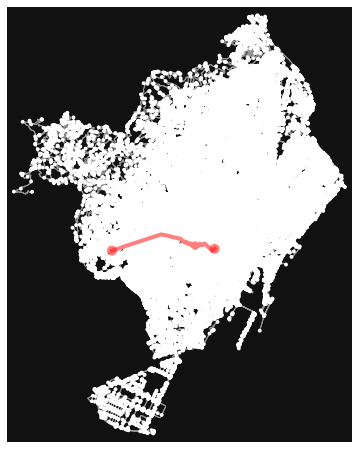

<Figure size 432x288 with 0 Axes>

In [90]:
fig, ax = ox.plot_graph_route(graph_bcn_prj, route)
plt.tight_layout()

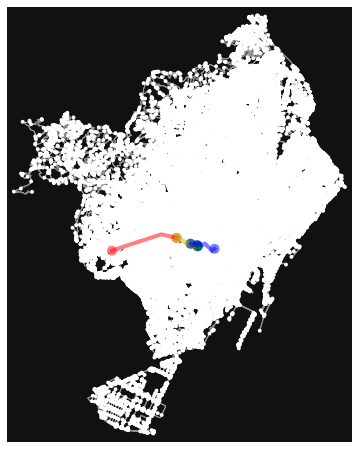

<Figure size 432x288 with 0 Axes>

In [91]:
if len(selected_locals) > 4:
    routes = [route_1, route_2, route_3, route_4, route_5, route_6]
    rc = ['r', 'y', 'c', 'b', 'g', 'b']
    fig, ax = ox.plot_graph_routes(graph_bcn_prj, routes, route_colors=rc)
    plt.tight_layout()

To get a slightly more detailed graph, let's follow the procedure in the *network_analysis_experiments* notebook.

In [92]:
o_closest = nodes_bcn_prj.loc[orig_node]
t_closest = nodes_bcn_prj.loc[target_node]

In [93]:
routes_nodes = pd.DataFrame()
for i in range(0, len(routes)):
    #routes_nodes = pd.concat(routes_nodes,[nodes_proj.loc[routes[i]]])
    routes_nodes = routes_nodes.append([nodes_bcn_prj.loc[routes[i]]])

route_line = LineString(list(routes_nodes.geometry.values))

In [94]:
route_geom = gpd.GeoDataFrame(crs=edges_bcn_prj.crs)

route_geom['geometry'] = None
route_geom['osmids'] = None
route_geom.loc[0, 'geometry'] = route_line
route_geom.loc[0, 'osmids'] = str(list(routes_nodes.index.values)) #Getting OSMID values
route_geom['length_m'] = route_geom.length

In [95]:
od_points = gpd.GeoDataFrame(crs=edges_bcn_prj.crs)

od_points['geometry'] = None

od_points['type'] = None
od_points.loc[0, ['geometry', 'type']] = source_point, 'Origin'
od_points.loc[1, ['geometry', 'type']] = target_point, 'Target'
od_points.head()

,geometry,type
0,POINT (426153.571 4581907.927),Origin
1,POINT (430112.555 4581979.665),Target


In [96]:
buildings = ox.geometries_from_place('Barcelona', tags = {'building': True} )
buildings_proj = buildings.to_crs(crs=edges_bcn_prj.crs)

In [97]:
stop_points = gpd.GeoDataFrame(crs=edges_bcn_prj.crs)

stop_points['geometry'] = None

stop_points['type'] = None
stop_points.loc[0, ['geometry', 'type']] = source_point, 'Origin'

if len(selected_locals) > 0:
    stop_points.loc[1, ['geometry', 'type']] = target_1, 'Stop1'
if len(selected_locals) > 1:
    stop_points.loc[2, ['geometry', 'type']] = target_2, 'Stop2'
if len(selected_locals) > 2:
    stop_points.loc[3, ['geometry', 'type']] = target_3, 'Stop3'
if len(selected_locals) > 3:
    stop_points.loc[4, ['geometry', 'type']] = target_4, 'Stop4'
if len(selected_locals) > 4:
    stop_points.loc[5, ['geometry', 'type']] = target_5, 'Stop5'

stop_points.loc[6, ['geometry', 'type']] = target_point, 'Target'
stop_points.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  """Entry point for launching an IPython kernel.
<string>:6: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3162: FutureWarning: The input object of type 'Point' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Point', or assign to an empty array created with `np.empty(correct_shape, dtype=ob

,geometry,type
0,POINT (426153.571 4581907.927),Origin
1,POINT (428662.000 4582391.000),Stop1
2,POINT (429467.000 4582079.000),Stop2
3,POINT (429426.000 4582133.000),Stop3
4,POINT (429467.000 4582079.000),Stop4


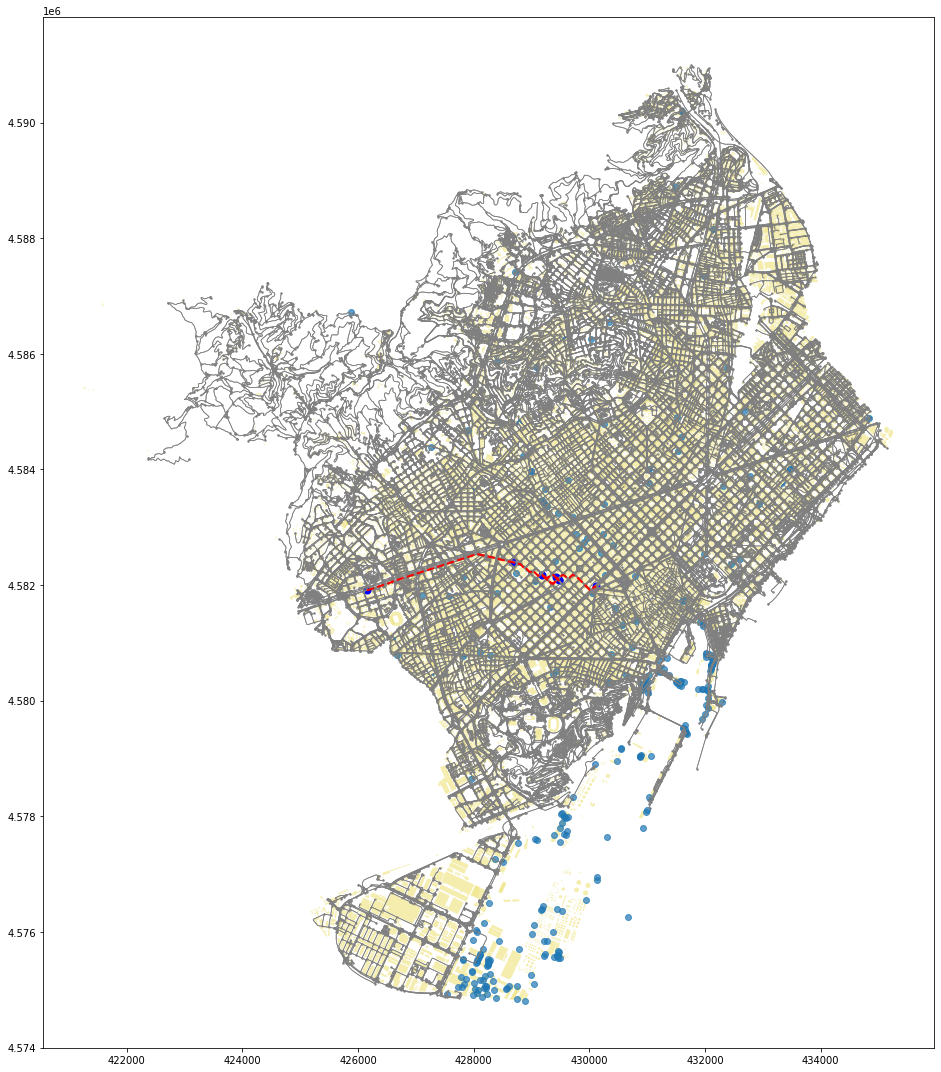

In [99]:
fig, ax = plt.subplots(figsize=(15,15))

edges_bcn_prj.plot(ax=ax, linewidth=0.75, color='gray')
nodes_bcn_prj.plot(ax=ax, markersize=2, color='gray')
buildings_proj.plot(ax=ax, facecolor='khaki', alpha=0.7)
route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')
od_points.plot(ax=ax, markersize=24, color='green')
stop_points.plot(ax=ax, markersize=50, color='blue')

plt.tight_layout()

We can obtain now the lenght of the route.

In [100]:
print(route_geom.length)

0    5401.681654
dtype: float64


<a id="shapefiles"></a>

<h3 style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: blue; background-color: #ffffff;" id="second">2.2. Shortest Route Selection (2nd option)</h3>

Let us now look at the second option. In this one, instead of randomly choosing the end point, we choose those 5 (if there are so many) that minimise the final path. This process, a priori, seems to be more computationally expensive than the previous one, because all the possible routes must be calculated to find the minimum one.

We have a list of the indexes of the locals that the user is interested in.

In [101]:
locals_user_ = locals_user[locals_user['Selected_Categories'] == interest].index

print(len(locals_user_))

9


Now, we can create the minimum route going for the establishments. If the number of locals is lower than 6, the route will go through all of them. If it is higher than 6, we will calculated the minimal route going by 5 of the establishments.

In [102]:
locals_user_ = locals_user[locals_user['Selected_Categories'] == interest].index
orig_node = ox.get_nearest_node(graph_bcn_prj, orig_xy, method='euclidean')
target_node = ox.get_nearest_node(graph_bcn_prj, target_xy, method='euclidean')
locals_user_df = pd.DataFrame(locals_user_)

if len(selected_locals) == 0:
    route = nx.shortest_path(G=graph_bcn_prj, source=orig_node, target=target_node, weight='length')    


if len(selected_locals) == 1:
    target_1 = Point(pd.to_numeric(df_choice.iloc[0].X), df_choice.iloc[0].Y)

    target_1_xy = (target_1.y, target_1.x)
    target_1_node = ox.get_nearest_node(graph_bcn_prj, target_1_xy, method='euclidean')

    route_1 = nx.shortest_path(G=graph_bcn_prj, source=orig_node, target=target_1_node, weight='length')
    route_2 = nx.shortest_path(G=graph_bcn_prj, source=target_1_node, target=target_node, weight='length')

    route = route_1 + route_2[1:]


if len(selected_locals) == 2:
    target_1 = Point(pd.to_numeric(df_choice.iloc[0].X), df_choice.iloc[0].Y)
    target_2 = Point(pd.to_numeric(df_choice.iloc[1].X), df_choice.iloc[1].Y)

    target_1_xy = (target_1.y, target_1.x)
    target_1_node = ox.get_nearest_node(graph_bcn_prj, target_1_xy, method='euclidean')
    target_2_xy = (target_2.y, target_2.x)
    target_2_node = ox.get_nearest_node(graph_bcn_prj, target_2_xy, method='euclidean')

    route_1 = nx.shortest_path(G=graph_bcn_prj, source=orig_node, target=target_1_node, weight='length')
    route_2 = nx.shortest_path(G=graph_bcn_prj, source=target_1_node, target=target_2_node, weight='length')
    route_3 = nx.shortest_path(G=graph_bcn_prj, source=target_2_node, target=target_node, weight='length')

    route = route_1 + route_2[1:] + route_3[1:]


if len(selected_locals) == 3:
    target_1 = Point(pd.to_numeric(df_choice.iloc[0].X), df_choice.iloc[0].Y)
    target_2 = Point(pd.to_numeric(df_choice.iloc[1].X), df_choice.iloc[1].Y)
    target_3 = Point(pd.to_numeric(df_choice.iloc[2].X), df_choice.iloc[2].Y)

    target_1_xy = (target_1.y, target_1.x)
    target_1_node = ox.get_nearest_node(graph_bcn_prj, target_1_xy, method='euclidean')
    target_2_xy = (target_2.y, target_2.x)
    target_2_node = ox.get_nearest_node(graph_bcn_prj, target_2_xy, method='euclidean') 
    target_3_xy = (target_3.y, target_3.x)
    target_3_node = ox.get_nearest_node(graph_bcn_prj, target_3_xy, method='euclidean')   

    route_1 = nx.shortest_path(G=graph_bcn_prj, source=orig_node, target=target_1_node, weight='length')
    route_2 = nx.shortest_path(G=graph_bcn_prj, source=target_1_node, target=target_2_node, weight='length')
    route_3 = nx.shortest_path(G=graph_bcn_prj, source=target_2_node, target=target_3_node, weight='length')
    route_4 = nx.shortest_path(G=graph_bcn_prj, source=target_3_node, target=target_node, weight='length')

    route = route_1 + route_2[1:] + route_3[1:] + route_4[1:]


if len(selected_locals) == 4:
    target_1 = Point(pd.to_numeric(df_choice.iloc[0].X), df_choice.iloc[0].Y)
    target_2 = Point(pd.to_numeric(df_choice.iloc[1].X), df_choice.iloc[1].Y)
    target_3 = Point(pd.to_numeric(df_choice.iloc[2].X), df_choice.iloc[2].Y)
    target_4 = Point(pd.to_numeric(df_choice.iloc[3].X), df_choice.iloc[3].Y)

    target_1_xy = (target_1.y, target_1.x)
    target_1_node = ox.get_nearest_node(graph_bcn_prj, target_1_xy, method='euclidean')
    target_2_xy = (target_2.y, target_2.x)
    target_2_node = ox.get_nearest_node(graph_bcn_prj, target_2_xy, method='euclidean') 
    target_3_xy = (target_3.y, target_3.x)
    target_3_node = ox.get_nearest_node(graph_bcn_prj, target_3_xy, method='euclidean') 
    target_4_xy = (target_4.y, target_4.x)
    target_4_node = ox.get_nearest_node(graph_bcn_prj, target_4_xy, method='euclidean') 

    route_1 = nx.shortest_path(G=graph_bcn_prj, source=orig_node, target=target_1_node, weight='length')
    route_2 = nx.shortest_path(G=graph_bcn_prj, source=target_1_node, target=target_2_node, weight='length')
    route_3 = nx.shortest_path(G=graph_bcn_prj, source=target_2_node, target=target_3_node, weight='length')
    route_4 = nx.shortest_path(G=graph_bcn_prj, source=target_3_node, target=target_4_node, weight='length')
    route_5 = nx.shortest_path(G=graph_bcn_prj, source=target_4_node, target=target_node, weight='length') 

    route = route_1 + route_2[1:] + route_3[1:] + route_4[1:] + route_5[1:]


if len(locals_user_) > 4:

    dist = 9999999999999
    i = 0

    for combi in combinations(range(0, len(locals_user_)), 5):  # 2 for pairs, 3 for triplets, etc

        if combi[0] < combi[1] < combi[2] < combi[3] < combi[4]:

            combi = pd.to_numeric(combi)
            combi.tolist()
            
            selected_locals = locals_user_df[locals_user_df.index.isin(combi)]

            selected_locals = selected_locals[0].values
            df_choice = retail_bcn.loc[selected_locals]

            target_1 = Point(pd.to_numeric(df_choice.iloc[0].X), df_choice.iloc[0].Y)
            target_2 = Point(pd.to_numeric(df_choice.iloc[1].X), df_choice.iloc[1].Y)
            target_3 = Point(pd.to_numeric(df_choice.iloc[2].X), df_choice.iloc[2].Y)
            target_4 = Point(pd.to_numeric(df_choice.iloc[3].X), df_choice.iloc[3].Y)
            target_5 = Point(pd.to_numeric(df_choice.iloc[4].X), df_choice.iloc[4].Y)

            target_1_xy = (target_1.y, target_1.x)
            target_2_xy = (target_2.y, target_2.x)
            target_3_xy = (target_3.y, target_3.x)
            target_4_xy = (target_4.y, target_4.x)
            target_5_xy = (target_5.y, target_5.x)

            target_1_node = ox.get_nearest_node(graph_bcn_prj, target_1_xy, method='euclidean')
            target_2_node = ox.get_nearest_node(graph_bcn_prj, target_2_xy, method='euclidean')
            target_3_node = ox.get_nearest_node(graph_bcn_prj, target_3_xy, method='euclidean')
            target_4_node = ox.get_nearest_node(graph_bcn_prj, target_4_xy, method='euclidean')
            target_5_node = ox.get_nearest_node(graph_bcn_prj, target_5_xy, method='euclidean')

            dist_1 = nx.shortest_path_length(G=graph_bcn_prj, source=orig_node, target=target_1_node, weight='length')
            dist_2 = nx.shortest_path_length(G=graph_bcn_prj, source=target_1_node, target=target_2_node, weight='length')
            dist_3 = nx.shortest_path_length(G=graph_bcn_prj, source=target_2_node, target=target_3_node, weight='length')
            dist_4 = nx.shortest_path_length(G=graph_bcn_prj, source=target_3_node, target=target_4_node, weight='length')
            dist_5 = nx.shortest_path_length(G=graph_bcn_prj, source=target_4_node, target=target_5_node, weight='length')
            dist_6 = nx.shortest_path_length(G=graph_bcn_prj, source=target_5_node, target=target_node, weight='length')

            if dist_1 + dist_2 + dist_3 + dist_4 + dist_5 + dist_6 < dist:
                dist = dist_1 + dist_2 + dist_3 + dist_4 + dist_5 + dist_6

                target_1_def = target_1
                target_2_def = target_2
                target_3_def = target_3
                target_4_def = target_4
                target_5_def = target_5

                target_1_node_def = target_1_node
                target_2_node_def = target_2_node
                target_3_node_def = target_3_node
                target_4_node_def = target_4_node
                target_5_node_def = target_5_node
    
    route_1 = nx.shortest_path(G=graph_bcn_prj, source=orig_node, target=target_1_node_def, weight='length')
    route_2 = nx.shortest_path(G=graph_bcn_prj, source=target_1_node_def, target=target_2_node_def, weight='length')
    route_3 = nx.shortest_path(G=graph_bcn_prj, source=target_2_node_def, target=target_3_node_def, weight='length')
    route_4 = nx.shortest_path(G=graph_bcn_prj, source=target_3_node_def, target=target_4_node_def, weight='length')
    route_5 = nx.shortest_path(G=graph_bcn_prj, source=target_4_node_def, target=target_5_node_def, weight='length')
    route_6 = nx.shortest_path(G=graph_bcn_prj, source=target_5_node_def, target=target_node, weight='length')

    route = route_1 + route_2[1:] + route_3[1:] + route_4[1:] + route_5[1:] + route_6[1:]
 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function

We now have the final route. Let's look at it in a couple of quick plots. The first contains the entire route. The second plots the different segments we have between each stop and the next, in different colours.

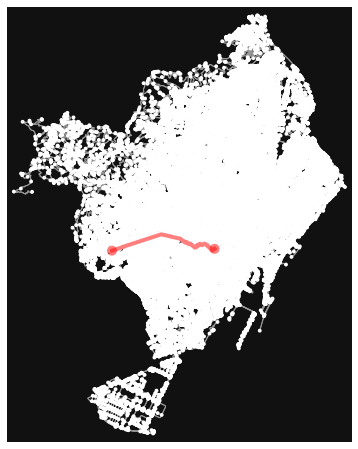

<Figure size 432x288 with 0 Axes>

In [103]:
fig, ax = ox.plot_graph_route(graph_bcn_prj, route)
plt.tight_layout()

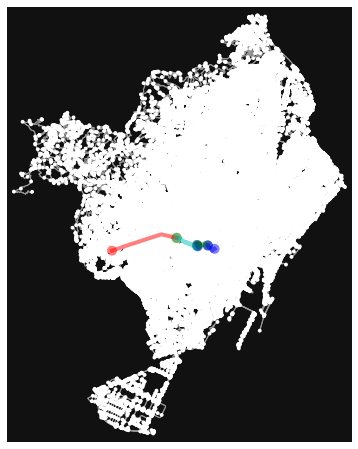

<Figure size 432x288 with 0 Axes>

In [104]:
if len(selected_locals) > 4:
    routes = [route_1, route_2, route_3, route_4, route_5, route_6]
    rc = ['r', 'y', 'c', 'b', 'g', 'b']
    fig, ax = ox.plot_graph_routes(graph_bcn_prj, routes, route_colors=rc)
    plt.tight_layout()

To get a slightly more detailed graph, let's follow the procedure in the *network_analysis_experiments* notebook.

In [105]:
o_closest = nodes_bcn_prj.loc[orig_node]
t_closest = nodes_bcn_prj.loc[target_node]

In [106]:
routes_nodes = pd.DataFrame()
for i in range(0, len(routes)):
    #routes_nodes = pd.concat(routes_nodes,[nodes_proj.loc[routes[i]]])
    routes_nodes = routes_nodes.append([nodes_bcn_prj.loc[routes[i]]])

route_line = LineString(list(routes_nodes.geometry.values))

In [107]:
route_geom = gpd.GeoDataFrame(crs=edges_bcn_prj.crs)

route_geom['geometry'] = None
route_geom['osmids'] = None
route_geom.loc[0, 'geometry'] = route_line
route_geom.loc[0, 'osmids'] = str(list(routes_nodes.index.values)) #Getting OSMID values
route_geom['length_m'] = route_geom.length

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  """Entry point for launching an IPython kernel.


In [108]:
od_points = gpd.GeoDataFrame(crs=edges_bcn_prj.crs)

od_points['geometry'] = None

od_points['type'] = None
od_points.loc[0, ['geometry', 'type']] = source_point, 'Origin'
od_points.loc[1, ['geometry', 'type']] = target_point, 'Target'
od_points.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  """Entry point for launching an IPython kernel.
<string>:6: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3162: FutureWarning: The input object of type 'Point' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Point', or assign to an empty array created with `np.empty(correct_shape, dtype=ob

,geometry,type
0,POINT (426153.571 4581907.927),Origin
1,POINT (430112.555 4581979.665),Target


In [109]:
buildings = ox.geometries_from_place('Barcelona', tags = {'building': True} )
buildings_proj = buildings.to_crs(crs=edges_bcn_prj.crs)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


In [110]:
stop_points = gpd.GeoDataFrame(crs=edges_bcn_prj.crs)

stop_points['geometry'] = None

stop_points['type'] = None
stop_points.loc[0, ['geometry', 'type']] = source_point, 'Origin'

if len(selected_locals) == 0:
    stop_points.loc[1, ['geometry', 'type']] = target_point, 'Target'

if len(selected_locals) == 1:
    stop_points.loc[1, ['geometry', 'type']] = target_1, 'Stop1'
    stop_points.loc[2, ['geometry', 'type']] = target_point, 'Target'

if len(selected_locals) == 2:
    stop_points.loc[1, ['geometry', 'type']] = target_1, 'Stop1'
    stop_points.loc[2, ['geometry', 'type']] = target_2, 'Stop2'
    stop_points.loc[3, ['geometry', 'type']] = target_point, 'Target'

if len(selected_locals) == 3:
    stop_points.loc[1, ['geometry', 'type']] = target_1, 'Stop1'
    stop_points.loc[2, ['geometry', 'type']] = target_2, 'Stop2'
    stop_points.loc[3, ['geometry', 'type']] = target_3, 'Stop3'
    stop_points.loc[4, ['geometry', 'type']] = target_point, 'Target'

if len(selected_locals) == 4:
    stop_points.loc[1, ['geometry', 'type']] = target_1, 'Stop1'
    stop_points.loc[2, ['geometry', 'type']] = target_2, 'Stop2'
    stop_points.loc[3, ['geometry', 'type']] = target_3, 'Stop3'
    stop_points.loc[4, ['geometry', 'type']] = target_4, 'Stop4'
    stop_points.loc[5, ['geometry', 'type']] = target_point, 'Target'

if len(selected_locals) > 4:
    stop_points.loc[1, ['geometry', 'type']] = target_1_def, 'Stop1'
    stop_points.loc[2, ['geometry', 'type']] = target_2_def, 'Stop2'
    stop_points.loc[3, ['geometry', 'type']] = target_3_def, 'Stop3'
    stop_points.loc[4, ['geometry', 'type']] = target_4_def, 'Stop4'
    stop_points.loc[5, ['geometry', 'type']] = target_5_def, 'Stop5'
    stop_points.loc[6, ['geometry', 'type']] = target_point, 'Target'


stop_points.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  """Entry point for launching an IPython kernel.
<string>:6: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3162: FutureWarning: The input object of type 'Point' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Point', or assign to an empty array created with `np.empty(correct_shape, dtype=ob

,geometry,type
0,POINT (426153.571 4581907.927),Origin
1,POINT (428682.000 4582381.000),Stop1
2,POINT (428662.000 4582391.000),Stop2
3,POINT (429467.000 4582079.000),Stop3
4,POINT (429426.000 4582133.000),Stop4


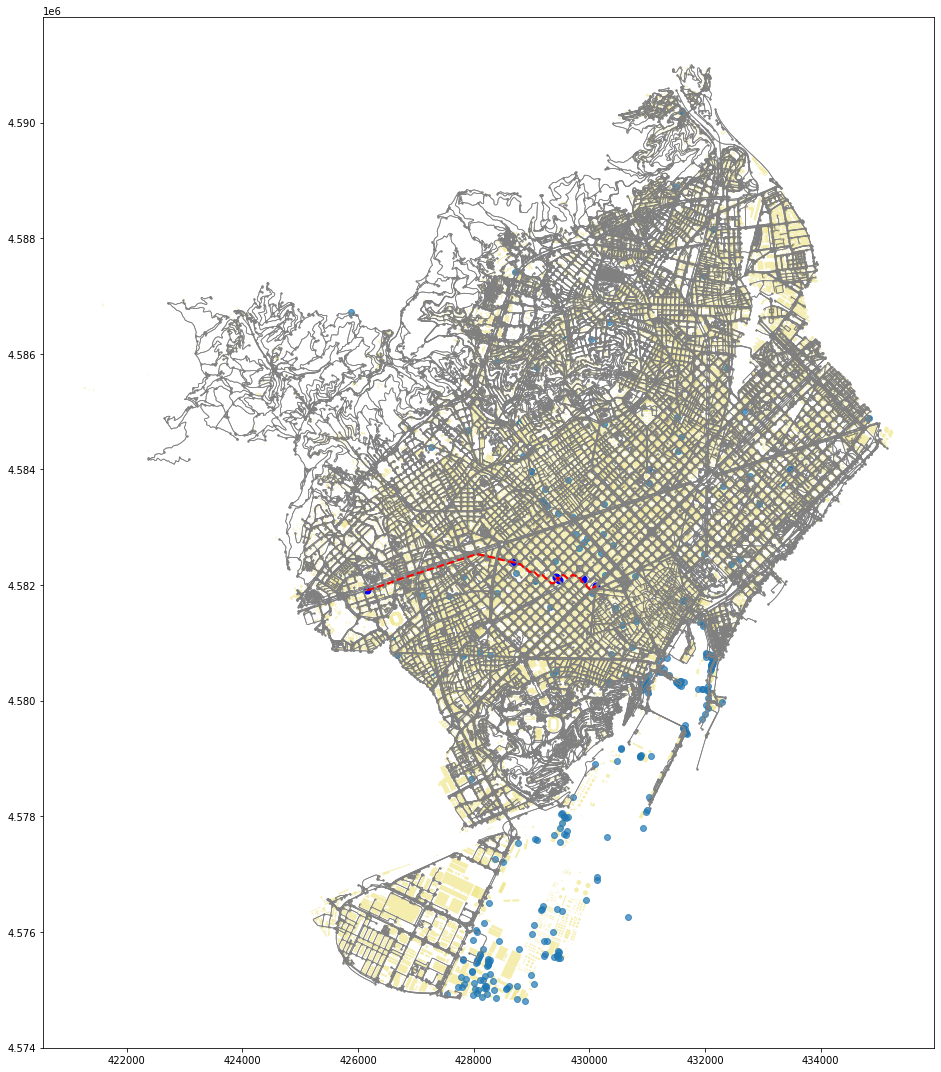

In [111]:
fig, ax = plt.subplots(figsize=(15,15))

edges_bcn_prj.plot(ax=ax, linewidth=0.75, color='gray')
nodes_bcn_prj.plot(ax=ax, markersize=2, color='gray')
buildings_proj.plot(ax=ax, facecolor='khaki', alpha=0.7)
route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')
od_points.plot(ax=ax, markersize=24, color='green')
stop_points.plot(ax=ax, markersize=50, color='blue')

plt.tight_layout()

We can obtain now the length of the route.

In [112]:
if len(selected_locals) > 4:
    print(dist)
else: 
    print(route_geom.length)

4679.904999999999


With these results we end the notebook related to the section 3.2.2.